<div align="right">
  Christopher Lüken-Winkels, Lukas Blecher
</div>
# Exercise 1

## 1. Monte-Carlo Simulation
$X \in \left[ 0,1\right], Y \in \{0,1\}$
$$p(Y = 0) = p(Y = 1) = \frac12$$with the density functions$$ f(X = x|Y = 0) = 2 − 2x\\ f(X = x|Y = 1) = 2x$$
Now we derive the CDF for both cases. In general the definition is $$F_X(x)=\int^x_{-\infty} f_X(t)dt$$
Since $X\in \left[0,1\right]$ we integrate form $0$. The results are:
$$F_0=\int_0^x (2y-y^2) dy =2x-x^2 \\ F_1(x)=\int_0^x 2y dy=x^2$$

Now we inverted the CDF:
$$F_0^{-1}(y)=1-\sqrt{1-y}\\ F_1^{-1}(y)=\sqrt y$$
In the first case we got two different solutions but the $+$-solution is greater than $1$ for almost all x.

### 1.1 Data Creation and Visualization

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rd
from scipy.optimize import curve_fit
%matplotlib inline

In [92]:
#define cumulative distribution function for f(X=x|Y=0)=2−2x (F0) and f(X=x|Y=1)=2x (F1)
def F0(x):
    return 2*x - x**2
def F1(x):
    return x**2

#define inverse functions of F0 (invF0) and F1 (invF1)
def invF0(y):
    return 1 - np.sqrt(1 - y)
def invF1(y):
    return np.sqrt(y)

#define function that returns vectors containing the X-values and corresponding Y-labels for N data instances
def create_data(N):
    Z = rd.random(N)
    X0 = invF0(Z[:int(N/2)])          #first half of set with Y=0
    X1 = invF1(Z[int(N/2):])          #second half of set with Y=1
    Y0 = np.zeros(len(X0))
    Y1 = np.ones(len(X1))
    return np.concatenate((X0,X1),axis=None),np.concatenate((Y0,Y1),axis=None)

#define function to show histogramm of X with Y=0 (second arg = 0) or Y=1 (second arg = 1)
def test(N,k):
    if not k in [0,1]:
        raise ValueError('k can only be 0 or 1.')
    X,Y = create_data(N)
    plt.title('Distribution of $F_{%i}(x)=$%s'%(k,['$2-2x$','$2x$'][k]))
    if k == 0:
        plt.hist(X[:int(len(X)/2)],bins = 100)
    if k == 1:
        plt.hist(X[int(len(X)/2):],bins = 100)
    plt.show()

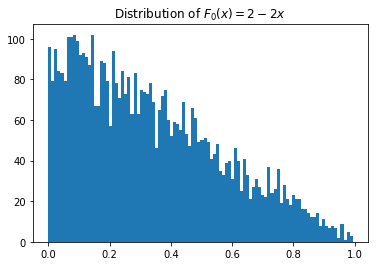

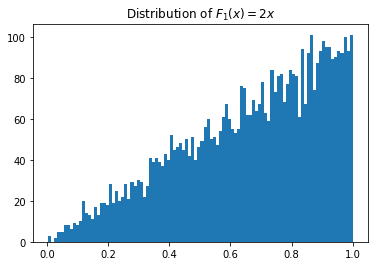

In [94]:
test(10000,0)
test(10000,1)

### 1.2 Classifcation by Thresholding

In [95]:
#set threshold to x_t
x_t = 0.5

def checkRule(rule):
    if not rule in [0,1,2,3]:
        raise ValueError('choose 0 (rule A), 1 (rule B), and so on for first arg')
#define rules of the classifier: Rule A (threshold classifier)[0], Rule B (threshold anti-classifier)[1]
#Rule C (guressing) and Rule D (contant)
def Y_hat(rule,x,x_t):    
    checkRule(rule)  
    return {0:0 if x < x_t else 1,
            1:1 if x < x_t else 0,
            2:round(rd.random()),
            3:1}[rule]
    
#define functionn to decide Y values for and array of X values
def decide(rule,X,x_t):
    Y_decision = []
    for x in X:
        Y_decision.append(Y_hat(rule,x,x_t))
    return np.array(Y_decision)

#define function to evaluate mean of abs(Y_hat-Y_star)
def error(rule,N,x_t):
    X,Y_star = create_data(N)
    Y = decide(rule,X,x_t)
    del_Y = abs(Y_star - Y)
    return np.mean(del_Y)

#evaluate error for x_t element of environment(0.5)
def minerror(N):
    X_t = np.linspace(0.4,0.6,100)
    Error = []
    for x_t in X_t:
        Error.append(error(0,N,x_t))
    Error = np.array(Error)
    
    return X_t,Error

#calculate error for x_t in {0.2,0.5,0.6}
def errorArray(rule,N,X_t):
    Err = []
    for x_t in X_t:
        Err.append(error(rule,N,x_t))
    return Err

#analytical solution
def theoError(rule,x_t):
    checkRule(rule)
    return {0:.25+(x_t-.5)**2,
            1:.75-(x_t-.5)**2,
            2:.5,
            3:.5}[rule]

#evaluate error for x_t element of environment(0.5)
def minerror(N):
    X_t = np.linspace(0.4,0.6,100)
    Error = []
    for x_t in X_t:
        Error.append(error(0,N,x_t))
    Error = np.array(Error)
    return X_t,Error

#gerneral parabola
def parabola(x,u,a,c):
    return a*(x-u)**2+c

In [80]:
X_t = np.array([0.2,0.5,0.6])
errorArray(0,10000,X_t) - theoError(0,X_t)

array([ 0.0065, -0.0027,  0.0025])

low values in the difference of numerical and theoretical solution indicate a correct theoratical error analysis

In [81]:
x,err=minerror(100000)

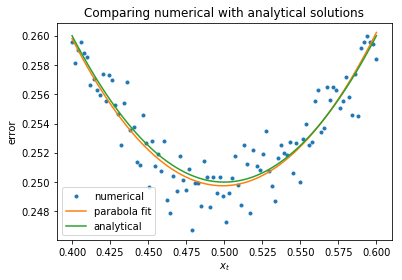

0.250692


In [82]:
popt,pcov=curve_fit(parabola,x,err)
plt.title('Comparing numerical with analytical solutions')
plt.plot(x,err,'.',label='numerical')
plt.plot(x,parabola(x,*popt),label='parabola fit')
plt.plot(x,theoError(0,x),label='analytical')
plt.xlabel('$x_t$')
plt.ylabel('error')
plt.legend()
plt.show()
print(error(0,1000000,0.5)) #not the value of the plot

as one can see the minimum error rate is located at about x_t = 0.5 with an error propability of about 25% as expected

In [96]:
#define function to evaluate mean and std for a set (size 10) of errors with same rule, N and x_t
def errorMeanStd(rule,N,x_t):
    Err = []
    for i in range (10):
        Err.append(error(rule,N,x_t))
    return np.mean(Err),np.std(Err)

In [97]:
#calculate mean and std for every combination of rule,N and x_t
#solution represented in form: [[x_t,rule,N,mean,std,theoretical value],[x_t,...],[...],...]
def showMeanStd(rules,Nlist,X_t):
    solution = []
    for x_t in X_t:
        for rule in rules:
            for N in Nlist:
                solution.append([x_t,rule,N,*errorMeanStd(rule,N,x_t),theoError(rule,x_t)])
    return solution

In [104]:
print('x_t,rule,N,mean,std,theo')
for a in showMeanStd([0,1,2,3],[10,100,1000,10000],[0.2,0.5,0.6]):
    print('%.1f, %i, %i, %.3f, %.3f, %.3f'%(*a,))

x_t,rule,N,mean,std,theo
0.2, 0, 10, 0.270, 0.119, 0.340
0.2, 0, 100, 0.356, 0.033, 0.340
0.2, 0, 1000, 0.342, 0.010, 0.340
0.2, 0, 10000, 0.340, 0.004, 0.340
0.2, 1, 10, 0.670, 0.100, 0.660
0.2, 1, 100, 0.656, 0.033, 0.660
0.2, 1, 1000, 0.663, 0.011, 0.660
0.2, 1, 10000, 0.660, 0.003, 0.660
0.2, 2, 10, 0.510, 0.170, 0.500
0.2, 2, 100, 0.491, 0.051, 0.500
0.2, 2, 1000, 0.499, 0.014, 0.500
0.2, 2, 10000, 0.498, 0.005, 0.500
0.2, 3, 10, 0.500, 0.000, 0.500
0.2, 3, 100, 0.500, 0.000, 0.500
0.2, 3, 1000, 0.500, 0.000, 0.500
0.2, 3, 10000, 0.500, 0.000, 0.500
0.5, 0, 10, 0.250, 0.136, 0.250
0.5, 0, 100, 0.234, 0.036, 0.250
0.5, 0, 1000, 0.251, 0.009, 0.250
0.5, 0, 10000, 0.248, 0.002, 0.250
0.5, 1, 10, 0.690, 0.176, 0.750
0.5, 1, 100, 0.726, 0.039, 0.750
0.5, 1, 1000, 0.750, 0.013, 0.750
0.5, 1, 10000, 0.751, 0.005, 0.750
0.5, 2, 10, 0.530, 0.155, 0.500
0.5, 2, 100, 0.521, 0.056, 0.500
0.5, 2, 1000, 0.505, 0.013, 0.500
0.5, 2, 10000, 0.500, 0.004, 0.500
0.5, 3, 10, 0.500, 0.000, 0.500
0.5, 

In [98]:
def errorStd(rules,Nlist,X_t):
    data = np.transpose(showMeanStd(rules,Nlist,X_t))
    Stds = data[4]
    solution = []
    setlenght = len(X_t)*len(rules)
    
    for i in range(0,len(Nlist)*setlenght,len(Nlist)):
        solution.append(Stds[i:i+len(Nlist)])
    return solution
        

In [111]:
#loglog line function
def logline(x,a,b):
    return a*x**b

No handles with labels found to put in legend.


probportional to x^b with b=-0.512 +/- 0.095


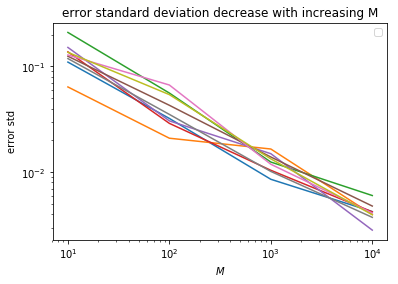

In [123]:
#plot the stds against M
M=[10,100,1000,10000]
stds = errorStd([0,1,2],M,[0.2,0.5,0.6])
plt.title('error standard deviation decrease with increasing M')
plt.xlabel('$M$')
plt.ylabel('error std')
#plt.yscale('log')
b=[]
for s in stds:
    popt,pcov=curve_fit(logline,M,s)
    plt.loglog(M,s,label='') #todo label data
    b.append(popt[1])
plt.legend()
print('probportional to x^b with b=%.3f +/- %.3f'%(np.mean(b),np.std(b)))
plt.show()

How does the error standard deviation decrease with increasing M?
we noticed that the error std decreases according to $a \cdot x^b$ so we fitted this function to our data. The result let's us belive that the std is proportional to $\dfrac1{\sqrt x}$.